In [ ]:
# default_exp core

# Module core

> Nipype and mrtrix3 based pre-/post- processing pipeline for brain diffusion-MRI and generation of structural connectomes of the brain. This module contains customized and up-to-date command line interfaces that are not found from Nipype's interfaces module. Additionally, steps in the preprocessing pipeline are listed as standalone I/O modules as examples and simplified version of the pipeline

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%%capture
#export
import os, sys
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, File
from nipype.interfaces.base import TraitedSpec, traits
from nipype.interfaces.io import BIDSDataGrabber
from bids.layout import BIDSLayout

import nibabel as nb
from nilearn import plotting
from nilearn.image import new_img_like

from nipype.interfaces import fsl
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.mrtrix3.utils import BrainMask
from nipype.interfaces.mrtrix3.preprocess import MRDeGibbs, DWIBiasCorrect

Environment testing:

In [ ]:
#test
# if our sample data can create BIDS layouts
data_dir = "/Users/xxie/sample_data/BIDS_output/"

## test datasets first:
data1 = os.path.join(data_dir)
# data2 = os.path.join(data_dir, 'healthy_control/')

layout = BIDSLayout(data1)
assert len(layout.get_subjects()) != 0
assert type(layout.get_subjects() is list)

# layout = BIDSLayout(data2)
# assert len(layout.get_subjects()) != 0
# assert type(layout.get_subjects() is list)

### BIDS Data Input

Get subjects from BIDS directory:

In [ ]:
#export
def get_subs(sub_dir="data"):
    """
    Gets list of subjects in a BIDS directory, by default it looks in "data" folder in your CWD
    Input str of path to BIDS dir otherwise
    """
    print(
        "Creating layout of data directory, might take a while if there are a lot of subjects"
    )
    layout = BIDSLayout(sub_dir)
    sub_list = layout.get_subjects()
    return sub_list, layout

In [ ]:
#example usage:
sub_list, layout = get_subs(data_dir)
print(sub_list)

Creating layout of data directory, might take a while if there are a lot of subjects
['01']


In [ ]:
#test
import glob
#if subjects were all grabbed
assert len(get_subs(data_dir)[0]) == len(glob.glob(data_dir+ '/sub-*'))

Creating layout of data directory, might take a while if there are a lot of subjects


Find FSL `.bval/.bvec` gradient file paths:

In [ ]:
# export
def get_bfiles_tuple(in_List):
    """
    read .bvec and .bval files in as a list and spit out tuple for nipype input
    """
    # bvs = layout.get(subject = sub_list[0], suffix = 'dwi', session = 1, extensions = ['bvec', 'bval'], return_type = 'file')
    bvs_tuple = tuple(in_List)[::-1]
    return bvs_tuple

In [ ]:
#example usage:
bfiles = layout.get(
    subject=sub_list[0],
    suffix="dwi",
    session='002',
    extensions=["bvec", "bval"],
    return_type="file",
) # here we are using session 002 as an example input
print(bfiles)
bfiles_fsl = get_bfiles_tuple(bfiles)
print(bfiles_fsl)

['/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bval', '/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bvec']
('/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bvec', '/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bval')


In [ ]:
#test
#if bfiles are grabbed
assert len(get_bfiles_tuple(bfiles)) == 2

Get dwi images:

In [ ]:
#example usage
dwi = layout.get(
    subject=sub_list[0],
    datatype="dwi",
    extensions=[".nii", ".nii.gz"],
    return_type="file",
)
print(dwi)

['/Users/xxie/sample_data/BIDS_output/sub-01/ses-001/dwi/sub-01_ses-001_dwi.nii.gz', '/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.nii.gz', '/Users/xxie/sample_data/BIDS_output/sub-01/ses-003/dwi/sub-01_ses-003_dwi.nii.gz']


In [ ]:
#test
#if all sessions are grabbed
assert len(dwi) == len(layout.get_sessions())

Get anatomical images:

In [ ]:
#example usage
anat = layout.get(
    subject=sub_list[0],
    datatype = 'anat',
    session='002',
    extensions=[".nii", ".nii.gz"],
    return_type="filename",
)
print(anat)

['/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/anat/sub-01_ses-002_T1w.nii.gz']


### Common inputs to `pipetography`'s command
This is mostly based off of the newly updated mrtrix3 commands, the new capabilities do not appear in the nipype interfaces so we need to add them:

In [ ]:
#export
class PipetographyBaseInputSpec(CommandLineInputSpec):
    export_grad = traits.Bool(
        argstr="-export_grad_mrtrix",
        desc="export new gradient files in mrtrix format",
        position=-3
    )
    out_bfile = File(
        "dwi.b",
        argstr="%s",
        desc="name of new gradient file",
        position=-2
    )
    grad_fsl = traits.Tuple(
        (traits.Str, traits.Str),
        argstr="-fslgrad %s %s",
        desc="provide gradient table in fsl format",
        xor=["grad_fsl"]
    )
    grad_file = File(
        exists=True,
        argstr="-grad %s",
        desc="dw gradient scheme (MRTrix format)",
        xor=["grad_file"],
    )
    nthreads = traits.Int(
        argstr="-nthreads %d",
        desc="number of threads. if zero, the number" " of available cpus will be used",
        nohash=True,
    )
    force = traits.Bool(
        argstr="-force", desc="force output file if the file already exits"
    )

#### ACPC MNI alignment (HCP Based), as seen on brainlife.io: 

This realigns our cropped anatomical image inputs to the MNI template using HCP pipeline procedure with FSL's `aff2rigid`. We want to do everything in MNI space.

In [ ]:
#export
class aff2rigidInputSpec(CommandLineInputSpec):
    """
    Specifying inputs to fsl's aff2rigid
    """
    in_file = File(
        exists=True, mandatory=True, argstr="%s", position=1, desc="FLIRT transform (12 DOF) from the input image to standard"
    )
    out_file = File(
        manndatory=True, argstr="%s", position=2, desc="output matrix which will go from the input image to standard space (6 DOF)"
    )
    
class aff2rigidOutputSpec(TraitedSpec):
    """
    Specifying outputs of aff2rigid
    """
    out_file = File(argstr="%s", desc="output matrix")
    
class fslaff2rigid(CommandLine):
    """
    Align cropped image the ACPC plane using FSL's aff2rigid
    """
    _cmd = "aff2rigid"
    input_spec = aff2rigidInputSpec
    output_spec = aff2rigidOutputSpec
    
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs 

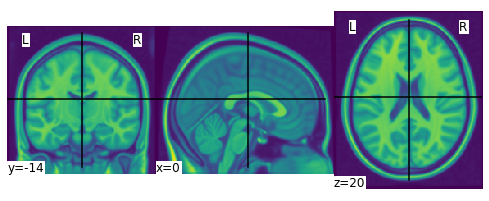

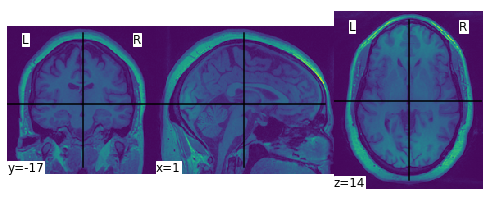

In [ ]:
#example
#usage:

rfov = fsl.utils.RobustFOV() # first reduce FOV of T1 image
rfov.inputs.in_file = anat[0]
rfov.inputs.out_transform = 'outputs/roi2full.mat'
rfov.inputs.out_roi = 'outputs/robustfov.nii.gz'
rfov.run() # run RobustFOV

inv_xfm = fsl.utils.ConvertXFM() # inverse transformation matrix
inv_xfm.inputs.in_file = 'outputs/roi2full.mat'
inv_xfm.inputs.invert_xfm = True
inv_xfm.inputs.out_file = 'outputs/full2roi.mat'
inv_xfm.run() 

temp_ref = os.path.expandvars('$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz')
flirt = fsl.preprocess.FLIRT()
flirt.inputs.in_file = 'outputs/robustfov.nii.gz'
flirt.inputs.reference = temp_ref
flirt.inputs.interp = 'spline'
flirt.inputs.out_matrix_file = 'outputs/roi2std.mat' 
flirt.inputs.out_file = 'outputs/acpc_mni.nii.gz'
flirt.run() # align acpc mni

concat = fsl.utils.ConvertXFM() # concatenate xfm
concat.inputs.in_file2 = 'outputs/roi2std.mat'
concat.inputs.in_file = 'outputs/full2roi.mat'
concat.inputs.concat_xfm = True
concat.inputs.out_file = 'outputs/full2std.mat'
concat.run()

affr = fslaff2rigid()
affr.inputs.in_file = 'outputs/full2std.mat'
affr.inputs.out_file = 'outputs/outputmatrix.mat'
affr.run()

warp = fsl.preprocess.ApplyWarp() # apply warp finally
warp.inputs.in_file = anat[0]
warp.inputs.relwarp = True
warp.inputs.interp = 'spline'
warp.inputs.ref_file = temp_ref
warp.inputs.out_file = 'outputs/acpc_t1.nii.gz'
warp.inputs.premat = 'outputs/outputmatrix.mat'
warp.run()

# if we visualize both the MNI template and aligned T1, they should be in the same coordinate system
template_img = nb.load(temp_ref)
template_data = template_img.get_fdata()
img = new_img_like(template_img, template_data, affine=template_img.affine, copy_header=True)
_ = plotting.plot_img(img)

acpc_img = nb.load('outputs/acpc_t1.nii.gz')
acpc_data = acpc_img.get_fdata()
t1_img = new_img_like(acpc_img, acpc_data, affine=acpc_img.affine, copy_header=True)
_ = plotting.plot_img(t1_img)

### Freesurfer `recon-all` for the ACPC-aligned image:

In [ ]:
#example
#usage
reconall = ReconAll()
reconall.inputs.directive = 'all'
# reconall.inputs.subject_id = 'sub-'+sub_list[0]
# reconall.inputs.subjects_dir = 'outputs/freesurfer'
reconall.inputs.subjects_dir = '/Users/xxie/sample_data/freesurfer'
reconall.inputs.T1_files = 'outputs/acpc_t1.nii'
reconall.inputs.hippocampal_subfields_T1 = True
reconall.inputs.parallel = True
reconall.inputs.openmp = 6
# reconall.cmdline
reconall.run()

!tree /Users/xxie/sample_data/freesurfer -L 2

/Users/xxie/sample_data/freesurfer
├── fsaverage -> /Applications/freesurfer/subjects/fsaverage
└── recon_all
    ├── label
    ├── mri
    ├── scripts
    ├── stats
    ├── surf
    ├── tmp
    ├── touch
    └── trash

10 directories, 0 files


#### Convert to mrtrix3 image file format:

In [ ]:
#export
class ConvertInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True, argstr="%s", mandatory=True, position=-4, desc="input image"
    )
    out_file = File(
        "dwi.mif",
        argstr="%s",
        mandatory=True,
        position=-1,
        usedefault=True,
        desc="output image",
    )
    coord = traits.List(
        traits.Float,
        sep=" ",
        argstr="-coord %s",
        desc="extract data at the specified coordinates",
    )
    vox = traits.List(
        traits.Float, sep=",", argstr="-vox %s", desc="change the voxel dimensions"
    )
    axes = traits.List(
        traits.Int,
        sep=",",
        argstr="-axes %s",
        desc="specify the axes that will be used",
    )
    scaling = traits.List(
        traits.Float,
        sep=",",
        argstr="-scaling %s",
        desc="specify the data scaling parameter",
    )


class ConvertOutputSpec(TraitedSpec):
    out_file = File(exists=True, desc="output image")
    out_bfile = File(desc="exported gradient file")


class Convert(CommandLine):
    _cmd = "mrconvert"
    input_spec = ConvertInputSpec
    output_spec = ConvertOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        try:
            outputs["out_file"] = os.path.abspath(self.inputs.out_file)
            outputs["out_bfile"] = os.path.abspath(self.inputs.out_bfile)
        except:
            print('There is no output gradient file')
        else:
            outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

In [ ]:
#example
#usage

# get session 2's dwi image:
dwi = layout.get(
    subject=sub_list[0],
    datatype="dwi",
    session='002',
    extensions=[".nii", ".nii.gz"],
    return_type='filename'
)
print(dwi)

mconvert = Convert()
mconvert.inputs.in_file = dwi[0]
mconvert.inputs.grad_fsl = bfiles_fsl
mconvert.inputs.out_file = 'outputs/raw_dwi.mif'
mconvert.inputs.export_grad = True
mconvert.inputs.out_bfile = 'outputs/raw_dwi.b'
mconvert.inputs.force = True
mconvert.run()

# check out the new bfile in mrtrix3 format:
!head -n 5 outputs/raw_dwi.b

['/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.nii.gz']
# command_history: mrconvert -force -fslgrad /Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bvec /Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bval /Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.nii.gz -export_grad_mrtrix outputs/raw_dwi.b outputs/raw_dwi.mif  (version=3.0.0)
0 0 0 0
0.9921854444 0.07884946525 -0.09669956424 2000
0.3068129719 0.9514561533 0.02443334917 2000
-0.08367772189 0.4538619675 0.8871343491 2000


#### Create DWI processing mask:

mrconvert: [WARNING] image "outputs/b0_mask.nii.gz" contains non-rigid transform - qform will not be stored.
mrconvert: [WARNING] requested datatype (Bit) not supported - substituting with UInt8
mrconvert: [100%] copying from "outputs/b0_brain_dwi_mask.mif" to "outputs/b0_mask.nii.gz"
mrconvert: [100%] compressing image "outputs/b0_mask.nii.gz"


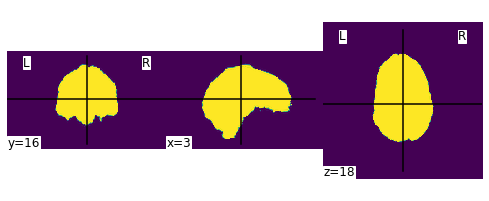

In [ ]:
#example
#usage

createMask = BrainMask()
createMask.inputs.in_file = 'outputs/raw_dwi.mif'
createMask.inputs.out_file = 'outputs/b0_brain_dwi_mask.mif'
createMask.run()

# visualize mask:
!mrconvert outputs/b0_brain_dwi_mask.mif outputs/b0_mask.nii.gz
b0mask = nb.load('outputs/b0_mask.nii.gz')  # display dwi
mask_data = b0mask.get_fdata()
img = new_img_like(b0mask, mask_data, affine=b0mask.affine, copy_header=True)
_ = plotting.plot_img(img)

#### Check gradient orientations and create corrected image:
The `dwigradcheck` functionality hasn't appeared in Nipype interfaces yet so we add it here

In [ ]:
#export
class GradCheckInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True,
        mandatory=True,
        argstr = '%s',
        position = 1,
        desc = "input DWI"
    )
    mask_file = File(
        exists=True,
        argstr="-mask %s",
        position = 3,
        desc = "input brain mask image option"
    )
    tract_number = traits.Int(
        argstr="-number %d",
        desc="number of tracts generated for each test",
        nohash=True,
    )
    
class GradCheckOutputSpec(TraitedSpec):
    out_bfile = File(
        argstr='%s', desc = "corrected gradient file"
    )
    
class GradCheck(CommandLine):
    """
    Check the input DWI's gradients with a provided brain mask and output the corrected gradients
    """
    _cmd = "dwigradcheck"
    input_spec = GradCheckInputSpec
    output_spec = GradCheckOutputSpec
    
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_bfile"] = os.path.abspath(self.inputs.out_bfile)
        return outputs

In [ ]:
#example
#usage

gradcheck = GradCheck()
gradcheck.inputs.mask_file = 'outputs/b0_brain_dwi_mask.mif'
gradcheck.inputs.in_file = 'outputs/raw_dwi.mif'
gradcheck.inputs.export_grad = True
gradcheck.inputs.out_bfile = 'outputs/corrected.b'
gradcheck.inputs.grad_file = 'outputs/raw_dwi.b'
gradcheck.inputs.force = True
gradcheck.cmdline
gradcheck.run()

# create new dwi image with corrected gradients:
mconvert = Convert()
mconvert.inputs.in_file = 'outputs/raw_dwi.mif'
mconvert.inputs.grad_file = 'outputs/corrected.b'
mconvert.inputs.out_file = 'outputs/cdwi.mif'
mconvert.inputs.force = True
mconvert.run()

# we should have the following mrtrix3 image files going into the preprocessing stages
!tree outputs -L 2 | grep .mif

There is no output gradient file
├── b0_brain_dwi_mask.mif
├── cdwi.mif
├── raw_dwi.mif


#### Denoise DWI:
This command exists in `nipype.interface`, but is missing some flags, so we customize it here: 

In [ ]:
#export
class dwidenoiseInputSpec(PipetographyBaseInputSpec):
    """
    Specifying inputs to dwidenoise
    """

    in_file = File(
        exists=True, mandatory=True, argstr="%s", position=1, desc="input image"
    )
    noise = File(
        mandatory=True, argstr="-noise %s", position=2, desc="output noise map"
    )
    out_file = File(
        mandatory=True, argstr="%s", position=-1, desc="output denoised image"
    )
    quiet = traits.Str(argstr="%s", position=3, desc="suppress verbose outputs")


class dwidenoiseOutputSpec(TraitedSpec):
    """
    Specifying outputs of dwidenoise
    """

    noise = File(argstr="%s", desc="output noise level map")
    out_file = File(argstr="%s", desc="output denoised file")


class dwidenoise(CommandLine):
    """
    Denoise DWI data with mrtrix3's dwidenoise.
    This should be performed as the first step of the preprocessing pipeline!
    Arguments:
        in_file (str): Input DWI image
        noise (str): output noise map
        out_file (str): output denoised image
        quiet (str): whether we should suppress output
        force (str): replace existing image (overwrite past runs outputs)
        nthreads (int): number of threads to use
    """

    _cmd = "dwidenoise"
    input_spec = dwidenoiseInputSpec
    output_spec = dwidenoiseOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["noise"] = os.path.abspath(self.inputs.noise)
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [WARNING] image "outputs/cdwi.nii.gz" contains non-rigid transform - qform will not be stored.
mrconvert: [100%] copying from "outputs/cdwi.mif" to "outputs/cdwi.nii.gz"
mrconvert: [100%] compressing image "outputs/cdwi.nii.gz"


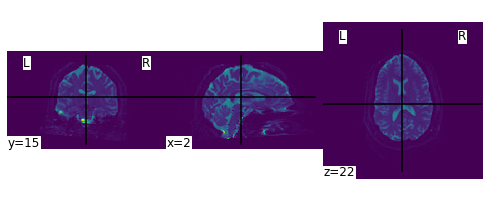

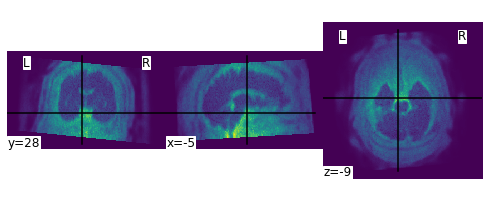

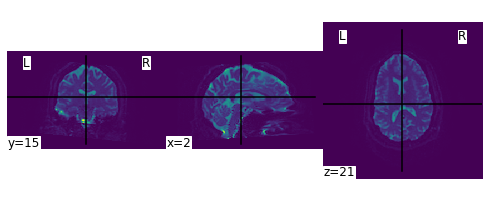

In [ ]:
#example
#usage:

# we will work with .nii.gz format for simpler visualization
denoise = dwidenoise()
denoise.inputs.out_file = "outputs/denoised.nii.gz"
denoise.inputs.noise = "outputs/noise.nii.gz"
denoise.inputs.in_file = "outputs/cdwi.mif"  # the first session's image
denoise.inputs.force = True
denoise.run()

# visualize:
!mrconvert outputs/cdwi.mif outputs/cdwi.nii.gz -force

orig_dwi = nb.load('outputs/cdwi.nii.gz')  # display dwi
orig_data = orig_dwi.get_fdata()[:, :, :, 0]
orig_img = new_img_like(orig_dwi, orig_data, affine=orig_dwi.affine, copy_header=True)
_ = plotting.plot_img(orig_img)

_ = plotting.plot_img(denoise.inputs.noise)

denoised_dwi = nb.load(denoise.inputs.out_file)
denoised_data = denoised_dwi.get_fdata()[:, :, :, 0]
denoised_img = new_img_like(
    denoised_dwi, denoised_data, affine=denoised_dwi.affine, copy_header=True
)
_ = plotting.plot_img(denoised_img)

In [ ]:
# # test if denoised file exists
#from fastcore.test import *
#
#test_eq(os.path.exists(denoise.inputs.noise), True)
#test_eq(os.path.exists(denoise.inputs.out_file), True)

### Gibb's ringing artifact removal:
You should run this step after denoise so you don't change the noise patterns before denoising. And this should also be done before `dwifslpreproc`.

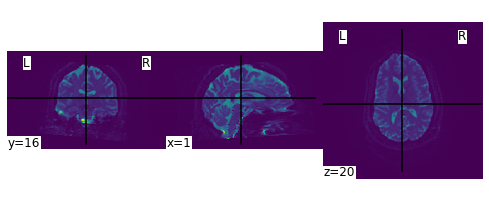

In [ ]:
#example
#usage

DeGibbs = MRDeGibbs()
DeGibbs.inputs.in_file  = 'outputs/denoised.nii.gz'
DeGibbs.inputs.out_file = 'outputs/degibbs.nii.gz'
DeGibbs.run()

# visualize:
degibbs_dwi = nb.load(DeGibbs.inputs.out_file)
degibbs_data = degibbs_dwi.get_fdata()[:, :, :, 0]
degibbs_img = new_img_like(
    degibbs_dwi, degibbs_data, affine=degibbs_dwi.affine, copy_header=True
)
_ = plotting.plot_img(degibbs_img)

### DWI Distortion correction
`dwipreproc` Was recently updated to `dwifslpreproc`, so we create the following commandline inputs, also `dwipreproc` doesn't exist in `Nipype`'s mrtrix3 interface:

In [ ]:
# export
class dwipreprocInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True,
        mandatory=True,
        argstr="%s",
        position=0,
        desc="input denoised, Gibbs artifact removed file",
    )
    rpe_options = traits.Str(
        mandatory=True,
        argstr="%s",
        position=3,
        desc="acquisition phase-encoding design",
    )
    pe_dir = traits.Str(
        mandatory=True, argstr="-pe_dir %s", position=4, desc="phase encoding direction"
    )
    eddy_options = traits.Str(
        mandatory=False,
        argstr="-eddy_options %s",
        position=2,
        desc="eddy command options within quotation marks and contains at least one space",
    )
    out_file = File(
        mandatory=True,
        argstr="%s",
        position=1,
        desc="output denoised, corrected, preproc image",
    )
    RO_time = traits.Float(
        argstr='-readout_time %f',
        position=-1,
        desc='total read out time, if unspecified defaults to 0.1'
    )


class dwipreprocOutputSpec(TraitedSpec):
    out_file = File(argstr="%s", desc="output denoised, corrected, preproc image")


class dwipreproc(CommandLine):
    """
    mrtrix3 dwipreproc for motion/eddy current correction
    Arguments: 
        in_file (str): input file that needs the artifact correction
        rpe_options (str): phase-encoding design, see mrtrix3's dwipreproc for detail options
        pe_dir (str): phase encoding directions, see mrtrix3's dwipreproc for detail options
        eddy_options (str): eddy current correction options. see mrtrix3's dwipreproc for detail options
        nthreads (int): number of threads used
        grad_fsl (tuple): bvec/bval files
        out_file (str): file name and path for output
    Returns:
        out_file (str): preprocessed file, this is the input to tractography.
    """

    _cmd = "dwifslpreproc"
    input_spec = dwipreprocInputSpec
    output_spec = dwipreprocOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

dwifslpreproc outputs/degibbs.nii.gz outputs/preproc.nii.gz -eddy_options "--slm=linear " -rpe_none -pe_dir j -force -grad outputs/corrected.b -readout_time 0.165240


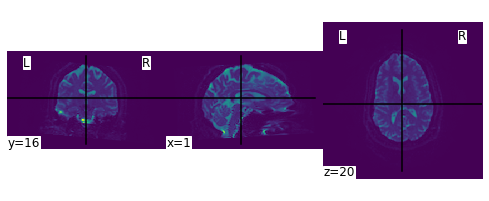

In [ ]:
#example
#usage:

# this example is for basic DWI acquisition
# all image volumes are acquired in a single protocol with fixed phase encoding:
preproc = dwipreproc()
preproc.inputs.in_file = 'outputs/degibbs.nii.gz' 
preproc.inputs.rpe_options = "-rpe_none"
preproc.inputs.eddy_options = '"--slm=linear "'
preproc.inputs.out_file = "outputs/preproc.nii.gz"
preproc.inputs.grad_file = gradcheck.inputs.out_bfile
preproc.inputs.force = True
# PyBIDS Can also extract meta data:
preproc.inputs.RO_time = layout.get_metadata(dwi[0])['TotalReadoutTime']
preproc.inputs.pe_dir = layout.get_metadata(dwi[0])['PhaseEncodingDirection']
print(preproc.cmdline)
preproc.run()

# visualize:
preproc_dwi = nb.load(preproc.inputs.out_file)
preproc_data = preproc_dwi.get_fdata()[:, :, :, 0]
preproc_img = new_img_like(
    preproc_dwi, preproc_data, affine=preproc_dwi.affine, copy_header=True
)
_ = plotting.plot_img(preproc_img)

### Bias field correction with ANTs:
There are 3 important parameters:

`ants.b`: default is [100,3], the values stand for [Initial mesh resolution in mm, spline order]. ANTS' N4BiasFieldCorrection option -b. This value is optimised for human adult data and needs to be adjusted for rodent data.

`ants.c`: default is [1000,0.0] or [numberOfIterations,convergenceThreshold], Equivalent to ANTS' N4BiasFieldCorrection option -c. 

`ants.s`: default is 4 N4BiasFieldCorrection option -s. shrink-factor applied to spatial dimensions

The current `Nipype` interface doesn't support the additional commandline arguments for `ANTS` in the correct order, AND their flags for certain inputs are outdated. So we create our own:

In [ ]:
#export
class BiasCorrectInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True, argstr="%s", position=1, mandatory=True, desc="input DWI image"
    )
    in_mask = File(argstr="-mask %s", desc="input mask image for bias field estimation")
    use_ants = traits.Bool(
        argstr="ants",
        mandatory=True,
        desc="use ANTS N4 to estimate the inhomogeneity field",
        position = 0,
        xor=["use_fsl"],
    )
    use_fsl = traits.Bool(
        argstr="fsl",
        mandatory=True,
        desc="use FSL FAST to estimate the inhomogeneity field",
        position = 0,
        xor=["use_ants"],
    )
    bias = File(argstr="-bias %s", desc="bias field")
    out_file = File(
        name_template="%s_biascorr",
        name_source="in_file",
        keep_extension=True,
        argstr="%s",
        position=2,
        desc="the output bias corrected DWI image",
        genfile=True,
    )
    args = traits.Str(
        argstr="%s",
        desc="additional arguments to ANTS or FSL",
        position=1
    )
    
    
class BiasCorrectOutputSpec(TraitedSpec):
    bias = File(desc="the output bias field", exists=True)
    out_file = File(desc="the output bias corrected DWI image", exists=True)
    
    
class BiasCorrect(CommandLine):
    _cmd = "dwibiascorrect"
    input_spec = BiasCorrectInputSpec
    output_spec = BiasCorrectOutputSpec
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        outputs['bias'] = os.path.abspath(self.inputs.bias)
        # Get the attribute saved during _run_interface
        return outputs


dwibiascorrect ants outputs/preproc.nii.gz outputs/dwi_bias.nii.gz -bias outputs/biasfield.nii.gz -grad outputs/corrected.b


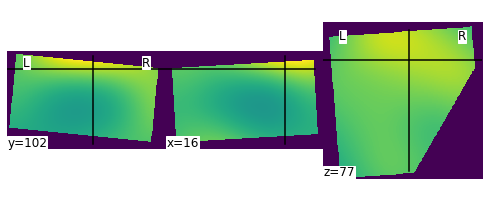

In [ ]:
#example
#usage

N4BiasCorrect = BiasCorrect()
N4BiasCorrect.inputs.use_ants = True
N4BiasCorrect.inputs.in_file = preproc.inputs.out_file
N4BiasCorrect.inputs.out_file = 'outputs/dwi_bias.nii.gz'
N4BiasCorrect.inputs.bias = 'outputs/biasfield.nii.gz'
N4BiasCorrect.inputs.grad_file = gradcheck.inputs.out_bfile
# We use the default values provided by brainlife.io as a test:
N4BiasCorrect.inputs.args = "-ants.b [150,3] -ants.c [200x200, 1e-6] -ants.s 2"
print(N4BiasCorrect.cmdline)
N4BiasCorrect.run()

# visualize the output bias field:
bias_dwi = nb.load(N4BiasCorrect.inputs.bias)
bias_data = bias_dwi.get_fdata() # try ...
bias_img = new_img_like(
    bias_dwi, bias_data, affine=bias_dwi.affine, copy_header=True
)
_ = plotting.plot_img(bias_img)

In [ ]:
# export
class N4BiasFieldCorrectionInputSpec(CommandLineInputSpec):
    """
    Input specifications
    """

    in_file = File(
        exists=True,
        mandatory=True,
        argstr="-i %s",
        position=1,
        desc="input denoised file",
    )
    dims = traits.Int(
        mandatory=True, argstr="-d %d", position=0, desc="dimension of input image"
    )
    out_file = File(mandatory=True, argstr="-o %s", position=2, desc="the output image")


class N4BiasFieldCorrectionOutputSpec(TraitedSpec):
    """
    Output specifications
    """

    out_file = File(desc="output denoised and bias corrected file")


class N4BiasFieldCorrection(CommandLine):
    """
    ANTs Bias field correction.
    Arguments:
        in_file (str) = input file, for the pipeline, connect the denoised dwi file here
        dims (int)    = input volume dimensions, for dwi's the value is 4
        outfile (str) = name of output file, for pipeline, connect this to datasink and next step
    Returns:
        out_file (str) = .nii.gz file output, bias field corrected image
    """

    _cmd = "N4BiasFieldCorrection"
    input_spec = N4BiasFieldCorrectionInputSpec
    output_spec = N4BiasFieldCorrectionOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        # Get the attribute saved during _run_interface
        return outputs

In [ ]:
#example
#usage
ants_bfc = N4BiasFieldCorrection()
ants_bfc.inputs.out_file = 'outputs/biasfieldcorrected.nii.gz'
ants_bfc.inputs.dims = 4
ants_bfc.inputs.in_file = 'outputs/denoised.nii.gz'
ants_bfc.run()

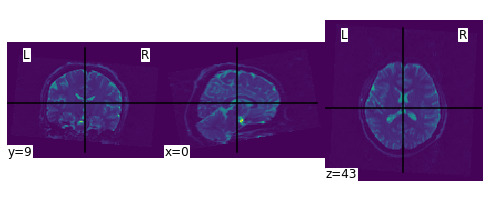

In [ ]:
#example
#visualize
corrected_dwi = nb.load('outputs/biasfieldcorrected.nii.gz')
corrected_data = corrected_dwi.get_fdata()[:, :, :, 0]  # first b0 volume
correctedb0_img = new_img_like(
    corrected_dwi, corrected_data, affine=corrected_dwi.affine, copy_header=True
)
_ = plotting.plot_img(correctedb0_img)

In [ ]:
# # test if file output is correct
#test_eq(os.path.exists('outputs/biasfieldcorrected.nii.gz'), True)

Brain extraction function input format:

In [ ]:
# export
def mask2seedtuple(mask_file, grid_size):
    seed_grid_tuple = (
        mask_file,
        grid_size,
    )
    return seed_grid_tuple